# Capstone 1 Data Wrangling

In this project, I will collect and clean the datasets that will be used in my Capstone 1

To begin, I downloaded the csv files for the 3 datasets from data.cityofchicago.org. The datasets used are:

1. Transportation Network Providers - Trips: https://data.cityofchicago.org/Transportation/Transportation-Network-Providers-Trips/m6dm-c72p
2. CTA - Ridership - 'L' Station Entries - Daily Totals: https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f
3. Chicago Traffic Tracker - Historical Congestion Estimates by Region - 2018-Current: https://data.cityofchicago.org/dataset/Chicago-Traffic-Tracker-Historical-Congestion-Esti/kf7e-cur8

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Previewing Data

I select the relevant columns from the datasets (all columns from the 'L' station dataset are used), then read the firse few rows of the csv using pandas read_csv function. These first few rows will be used to get a quick overview of the structure of the datasets and to find any potential problems that can be solved before processign the whole dataset.

Additionally, the read_csv call specifies that certain columns should be parsed as datetimes, and defines the index columns for the datasets.  
For the rideshare dataset, trip id is the index column.  
For the congestion dataset, time and region id together form the multiindex.  
Finally, date and station id form the multiindex for the 'L' station dataset.

In [26]:
# Define relevant columns for the datasets
rideshare_columns = [('Trip ID', 'trip_id'),
                     ('Trip Start Timestamp', 'start_time'),
                     ('Trip End Timestamp', 'end_time'),
                     ('Pickup Centroid Latitude', 'pickup_lat'),
                     ('Pickup Centroid Longitude', 'pickup_long'),
                     ('Dropoff Centroid Latitude', 'dropoff_lat'),
                     ('Dropoff Centroid Longitude', 'dropoff_long')]
rideshare_source_columns, rideshare_column_names = list(zip(*rideshare_columns)) 

congestion_columns = [('TIME','time'),
                      ('REGION_ID','region_id'),
                      ('SPEED','speed'),
                      ('REGION','region'),
                      ('BUS_COUNT','bus_count'),
                      ('NUM_READS','num_reads'),
                      ('WEST','west'),
                      ('EAST','east'),
                      ('SOUTH','south'),
                      ('NORTH','north')]
congestion_source_columns, congestion_column_names = list(zip(*congestion_columns)) 

station_columns = [('station_id', 'station_id'),
                   ('stationname', 'station_name'),
                   ('date', 'date'),
                   ('rides', 'rides')]
station_source_columns, station_column_names = list(zip(*station_columns)) 

# load dataframes from csv files
rideshares = pd.read_csv("data/rideshares_raw.csv", 
                         parse_dates=['Trip Start Timestamp', 'Trip End Timestamp'], 
                         usecols=rideshare_source_columns,
                         nrows=10000)
rideshares.columns = rideshare_column_names
rideshares = rideshares.set_index('trip_id')

congestion = pd.read_csv("data/congestion_raw.csv",
                         parse_dates=['TIME'],
                         usecols=congestion_source_columns,
                         #nrows=10000
                        )
congestion.columns = congestion_column_names
congestion = congestion.set_index(['time', 'region_id'])
congestion = congestion.sort_index()

station_entries = pd.read_csv("data/station_entries_raw.csv",
                              parse_dates=['date'],
                              usecols=station_source_columns,
                              #nrows=10000
                             )
station_entries.columns = station_column_names
station_entries = station_entries.set_index(['date', 'station_id'])
station_entries = station_entries.sort_index()


### Rideshare dataset preview

In [3]:
rideshares.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1e0d07bb2409f2e44980d2101d24cd1808fc1691 to 1e244b21b99860cdac7fea90566a02013b5c5b3e
Data columns (total 6 columns):
start_time      10000 non-null datetime64[ns]
end_time        10000 non-null datetime64[ns]
pickup_lat      9402 non-null float64
pickup_long     9402 non-null float64
dropoff_lat     9306 non-null float64
dropoff_long    9306 non-null float64
dtypes: datetime64[ns](2), float64(4)
memory usage: 546.9+ KB


From the first 1000 lines we can see that some of the entries lack pickup and dropoff locations. These entries will need to be cleaned. Otherwise, the data looks to be in good shape

In [37]:
rideshares.describe()

,pickup_lat,pickup_long,dropoff_lat,dropoff_long
count,9402.000000,9402.000000,9306.000000,9306.000000
mean,41.892275,-87.666035,41.893289,-87.668027
std,0.060939,0.062798,0.060665,0.066117
min,41.660136,-87.913625,41.660136,-87.913625
25%,41.877406,-87.679600,41.877406,-87.678688
50%,41.893216,-87.651311,41.893216,-87.651311
75%,41.929263,-87.631407,41.929330,-87.631407
max,42.021224,-87.534903,42.021224,-87.534903


### Congestion Dataset Preview

In [24]:
congestion.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2805719 entries, (2018-03-09 15:40:41, 1) to (2020-03-09 09:11:25, 29)
Data columns (total 8 columns):
speed        float64
region       object
bus_count    int64
num_reads    int64
west         float64
east         float64
south        float64
north        float64
dtypes: float64(5), int64(2), object(1)
memory usage: 185.5+ MB


congestion.info() shows that the columns seem to be properly formatted and complete.

In [25]:
congestion.describe()

,speed,bus_count,num_reads,west,east,south,north
count,2.805719e+06,2.805719e+06,2.805719e+06,2.805719e+06,2.805719e+06,2.805719e+06,2.805719e+06
mean,2.304333e+01,3.642927e+01,6.666114e+02,-8.770191e+01,-8.764235e+01,4.182452e+01,4.186771e+01
std,8.506232e+00,2.909417e+01,5.500713e+02,6.765980e-02,6.250787e-02,9.740192e-02,9.437662e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,-8.784621e+01,-8.774746e+01,4.164414e+01,4.167748e+01
25%,2.114000e+01,1.500000e+01,2.550000e+02,-8.774746e+01,-8.767459e+01,4.176407e+01,4.182279e+01
50%,2.455000e+01,3.100000e+01,5.470000e+02,-8.768537e+01,-8.764644e+01,4.182279e+01,4.186613e+01
75%,2.748000e+01,5.100000e+01,9.380000e+02,-8.764721e+01,-8.760633e+01,4.190927e+01,4.193184e+01
max,1.738600e+02,2.650000e+02,7.015000e+03,-8.758485e+01,-8.752444e+01,4.199795e+01,4.202644e+01


congestion.describe() shows that at least one entry has a speed of 0, which may indicate incomplete data. This may be an outlier. Additionally instances of bus_count and num_reads of 0 are likely missing data.

### 'L' station dataset preview

In [27]:
station_entries.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 988858 entries, (2001-01-01 00:00:00, 40010) to (2019-12-31 00:00:00, 41700)
Data columns (total 2 columns):
station_name    988858 non-null object
rides           988858 non-null int64
dtypes: int64(1), object(1)
memory usage: 18.9+ MB


station_entries.info() shows that this sample of the columns seem to be properly formatted and complete.

In [42]:
station_entries.describe()

,rides
count,988858.000000
mean,3322.844864
std,3215.420986
min,0.000000
25%,1123.000000
50%,2324.000000
75%,4351.000000
max,36323.000000


station_entries.describe() shows a wide range in the rides, including at least one value at 0, but visual inspection will have to be used to see if any entries seem to be outliers.

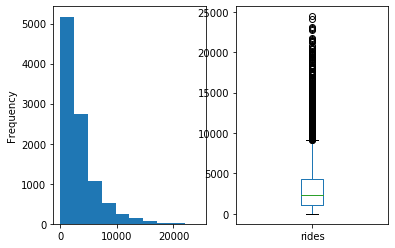

In [81]:
plt.subplot(1, 2, 1)
station_entries.rides.plot(kind='hist')
plt.subplot(1, 2, 2)
station_entries.rides.plot(kind='box')
plt.show()

With the visual inspection, the ridership frequency appears fairly smooth. The boxplot shows many outliers above the whisker, but there aren't any clear outliers that should be disconted.

## Full Dataset Processing

After previewing the datasets, I import the csv in chunks as a TextFileReader from pandas. This allows me to process the large datasets without overloading the memory, after which I will append the cleaned data chunk by chunk into a new csv.

In [34]:
rideshares_reader = pd.read_csv("data/rideshares_raw.csv", 
                                parse_dates=['Trip Start Timestamp', 'Trip End Timestamp'], 
                                usecols=rideshare_source_columns,
                                iterator=True,
                                chunksize=5000)

congestion_reader = pd.read_csv("data/congestion_raw.csv",
                                parse_dates=['TIME'],
                                usecols=congestion_source_columns,
                                iterator=True,
                                chunksize=5000)
station_entries_reader = pd.read_csv("data/station_entries_raw.csv",
                                     parse_dates=['date'],
                                     usecols=station_source_columns,
                                     iterator=True,
                                     chunksize=5000)

In [35]:
# Station Entries processing
firstChunk = True
for station_entries_chunk in station_entries_reader:
    # Drop entries with missing values
    station_entries_chunk = station_entries_chunk.dropna()
    
    if firstChunk:
        # Rename the columns for saving
        station_entries_chunk.columns = station_column_names
        # Save the first chunk normally
        station_entries_chunk.to_csv('data/station_entries.csv')
    else:
        # Append the second chunk and don't include the header
        station_entries_chunk.to_csv('data/station_entries.csv', mode='a', header=False)
    firstChunk = False

In [36]:
#Congestion Processing
firstChunk = True
for congestion_chunk in congestion_reader:
    # Drop entries with missing values
    congestion_chunk = congestion_chunk.dropna()
    # Drop entries with speed 0
    congestion_chunk.drop(congestion_chunk.loc[congestion_chunk["SPEED"]==0].index, inplace=True)
    # Drop entries with bus_count 0
    congestion_chunk.drop(congestion_chunk.loc[congestion_chunk["BUS_COUNT"]==0].index, inplace=True)
    # Drop entries with num_reads 0
    congestion_chunk.drop(congestion_chunk.loc[congestion_chunk["NUM_READS"]==0].index, inplace=True)
    
    if firstChunk:
        # Rename the columns for saving
        congestion_chunk.columns = congestion_column_names
        # Save the first chunk normally
        congestion_chunk.to_csv('data/congestion.csv')
    else:
        # Append the second chunk and don't include the header
        congestion_chunk.to_csv('data/congestion.csv', mode='a', header=False)
    firstChunk = False

In [ ]:
#Rideshare Processing
firstChunk = True
for rideshares_chunk in rideshares_reader:
    # Drop entries with missing values
    rideshares_chunk = rideshares_chunk.dropna()
    
    if firstChunk:
        # Rename the columns for saving the first chunk
        rideshares_chunk.columns = rideshare_column_names
        # Save the first chunk normally
        rideshares_chunk.to_csv('data/rideshares.csv')
    else:
        # Append the second chunk and don't include the header
        rideshares_chunk.to_csv('data/rideshares.csv', mode='a', header=False)
    firstChunk = False

## Sampling processed data

In [85]:
# load dataframes from csv files, including correct index
rideshares_clean = pd.read_csv("data/rideshares.csv", 
                               parse_dates=['start_time', 'end_time'], 
                               index_col='trip_id',
                               nrows=10000
                              )

congestion_clean = pd.read_csv("data/congestion.csv",
                               parse_dates=['time'],
                               index_col=['time', 'region_id'],
                              )
congestion_clean = congestion_clean.sort_index()

station_entries_clean = pd.read_csv("data/station_entries.csv",
                                    parse_dates=['date'],
                                    #index_col=['date', 'station_id'],
                                   )
station_entries_clean = station_entries_clean.sort_index()

/home/alicia/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
# Rideshares data
rideshares_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1e0d07bb2409f2e44980d2101d24cd1808fc1691 to 1e27da3a9da1b73852fcce5019c3708ef4dbd9e4
Data columns (total 7 columns):
Unnamed: 0      10000 non-null int64
start_time      10000 non-null datetime64[ns]
end_time        10000 non-null datetime64[ns]
pickup_lat      10000 non-null float64
pickup_long     10000 non-null float64
dropoff_lat     10000 non-null float64
dropoff_long    10000 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 625.0+ KB


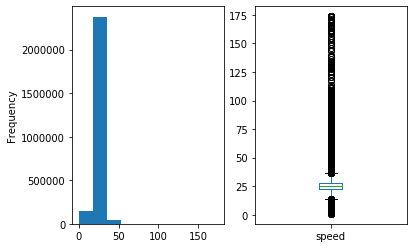

In [16]:
# Congestion Data
plt.subplot(1, 2, 1)
congestion_clean.speed.plot(kind='hist')
plt.subplot(1, 2, 2)
congestion_clean.speed.plot(kind='box')
plt.show()

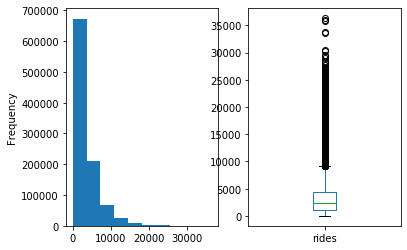

In [32]:
# 'L' Station Data
plt.subplot(1, 2, 1)
station_entries_clean.rides.plot(kind='hist')
plt.subplot(1, 2, 2)
station_entries_clean.rides.plot(kind='box')
plt.show()

## Combining Data
Now that I have cleaned the data, I combine the 3 datasets into one. Because the datasets have different levels of granularity, I must decide how to sample them to line them up most effectively. The Rideshare dataset has entries for every ride taken, while the congestion dataset has entries throughout the day at irregular intervals, and the 'L' station entries has daily entries. To begin with, I will downsample/upsample all of the datasets to hourly entries. For the rideshares I will count the number of rides in each day, separated into the same regions as the congestion dataset. For the congestion dataset I will average the speed. Finally, for the station dataset I will fill the daily entries data through the day.

Additionally, the station dataset will be reindexed to also use the same regions as the congestion dataset, instead of individual stations.

Finally, I will limit the entries to the overlapping time frame.

### Congestion Dataset

In [356]:
# Re-read congestion dataset from clean data file
congestion_clean = pd.read_csv("data/congestion.csv",
                               parse_dates=['time'],
                               index_col=['time', 'region_id'],
                              )
congestion_clean = congestion_clean.sort_index()

/home/alicia/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [357]:
# regroup the dataframe by the region id and resample with the same 30 minute interval.
resampled_congestion_clean = congestion_clean.reset_index(level=1)
resampled_congestion_clean = resampled_congestion_clean.groupby(['region_id']).resample('30T').mean()

# switch the levels of the multiindex and sort
resampled_congestion_clean = resampled_congestion_clean.swaplevel()
congestion = resampled_congestion_clean.sort_index()

In [358]:
congestion.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1017204 entries, (2018-03-09 15:30:00, 1) to (2020-03-09 09:00:00, 29)
Data columns (total 9 columns):
region_id     924690 non-null float64
Unnamed: 0    924690 non-null float64
speed         924690 non-null float64
bus_count     924690 non-null float64
num_reads     924690 non-null float64
west          924690 non-null float64
east          924690 non-null float64
south         924690 non-null float64
north         924690 non-null float64
dtypes: float64(9)
memory usage: 75.0 MB


### Extract region coordinates

In order to map the station and ridesharing datasets to the congestion datasets regions, I need to extract the region coordinates from the congestion dataset

In [17]:
# Select the first time entry in the dataframe
region_map = resampled_congestion_clean.loc['2018-03-09 15:30:00']

# Remove time as an index
region_map = region_map.reset_index(0)

# Drop unneeded columns
region_map = region_map.drop(columns=['time', 'region_id', 'Unnamed: 0', 'speed', 'bus_count', 'num_reads'])

In [19]:
region_map.head()

,west,east,south,north
region_id,,,,
1,-87.709645,-87.654561,41.997946,42.026444
2,-87.846210,-87.747456,41.960669,42.019100
3,-87.747456,-87.674590,41.960669,41.997946
4,-87.674590,-87.646438,41.960669,41.997946
5,-87.846210,-87.747456,41.909269,41.960669


### Station Dataset

In [359]:
# Re-read station dataset from clean data file, using a numerical index instead of the defined indices to allow for grouping
station_entries_clean = pd.read_csv("data/station_entries.csv",
                                    parse_dates=['date'],
                                   )

# Add date as an index and sort, then slice on the dates that overlap with the congestion dataset
station_entries_clean = station_entries_clean.set_index(['date', station_entries_clean.columns[0]])
station_entries_clean = station_entries_clean.sort_index()
station_entries_clean = station_entries_clean.loc[(slice('2018-03-09', '2020-03-09'), slice(None)), :]

In [360]:
# regroup the dataframe by the station id and resample with the same 30 minute interval.
resampled_station_entries_clean = station_entries_clean.reset_index(level=1)
resampled_station_entries_clean = resampled_station_entries_clean.groupby(['station_id']).resample('30T').ffill()

# switch the levels of the multiindex and sort
resampled_station_entries_clean = resampled_station_entries_clean.swaplevel()
resampled_station_entries_clean = resampled_station_entries_clean.sort_index()

In [361]:
resampled_station_entries_clean.head()

Unnamed: 0  station_id        station_name  rides
date       station_id                                                   
2018-03-09 40010           896380       40010  Austin-Forest Park   1854
           40020           884855       40020         Harlem-Lake   3660
           40030           884527       40030        Pulaski-Lake   1337
           40040           892953       40040        Quincy/Wells   7371
           40050           893818       40050               Davis   3824

In [362]:
# Extract list of all station name/id pairs
station_ids = resampled_station_entries_clean.station_id.unique()
station_names = resampled_station_entries_clean.station_name.unique()

#convert to dataframe
all_stations = pd.DataFrame(station_names, columns=['station_name'], index=station_ids)

Now that I have all of the stations, I need to find their coordinates and add them to the dataframe. I do this with the google maps geocoding API

In [363]:
# importing api key and setting up for api call
from keys import googleapi
import requests
url = 'https://maps.googleapis.com/maps/api/geocode/json'

In [364]:
# create function to get lat and long from the api using the station name
def get_coords( station_name ):
    """Returns the latitude and longitude of the station as a tuple, or false"""
    try:
        response = requests.get(url+'?address='+station_name+' Station Chicago&key='+googleapi.key)
        location = response.json()['results'][0]['geometry']['location']
        coords = (location['lat'], location['lng'])
        return coords
    except:
        return false

# Find the coordinates using the api
coords = [get_coords(station_name) for station_name in all_stations.station_name]

# Split the coorinates into lat and long lists
lat, long = zip(*coords)

In [365]:
# Finally, add the lat and long lists as columns to the stations dataframe
all_stations['lat'] = lat
all_stations['long'] = long
all_stations.head()

,station_name,lat,long
40010,Austin-Forest Park,41.874267,-87.816595
40020,Harlem-Lake,41.886872,-87.803959
40030,Pulaski-Lake,41.885567,-87.726692
40040,Quincy/Wells,41.878846,-87.633887
40050,Davis,42.047986,-87.684652


Now that I have mapped the stations to their coordinates, I can map them to their region, as extracted from the congestion dataset

In [366]:
# create function to match station to region
def find_station_region( station_id ):
    '''Returns region id matching the station coordinates, or 0 if no matching region'''
    lat, long = (all_stations.loc[station_id, 'lat'], all_stations.loc[station_id, 'long'])
    for region in region_map.iterrows():
        if (lat >= region[1]['south'] and lat <= region[1]['north'] and long >= region[1]['west'] and long <= region[1]['east']):
            return region[0]
    return 0

In [367]:
# create list of regions for all the stations
station_regions = [find_station_region(station_index[1])
                   for station_index
                   in resampled_station_entries_clean.index]

In [116]:
# Add the list to the stations dataframe
resampled_station_entries_clean['region_id'] = station_regions
resampled_station_entries_clean.head()

Unnamed: 0  station_id        station_name  rides  \
date       station_id                                                      
2018-03-09 40010           896380       40010  Austin-Forest Park   1854   
           40020           884855       40020         Harlem-Lake   3660   
           40030           884527       40030        Pulaski-Lake   1337   
           40040           892953       40040        Quincy/Wells   7371   
           40050           893818       40050               Davis   3824   

                       region_index  
date       station_id                
2018-03-09 40010                  0  
           40020                  0  
           40030                 10  
           40040                 13  
           40050                  0

In [139]:
# aggregate the dataframe on the regions
station_entries = pd.DataFrame(resampled_station_entries_clean.groupby(['date', 'region_id'])['rides'].sum())
station_entries.head()

rides
date       region_id       
2018-03-09 0          64514
           1          16035
           2          14927
           3          15011
           4          27565

Finally, I can slice the dataframe to only select the exact overlap with the congestion dataset, and remove the stations that are not in a region (region 0)

In [148]:
station_entries = station_entries.loc[(slice('2018-03-09 15:30:00', '2020-03-09 09:00:00'), slice(1, 29)), :]

In [149]:
station_entries.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 698412 entries, (2018-03-09 15:30:00, 1) to (2019-12-31 00:00:00, 29)
Data columns (total 1 columns):
rides    698412 non-null int64
dtypes: int64(1)
memory usage: 7.6 MB


### Rideshare dataset

In [339]:
# Re-read rideshare dataset from clean data file
rideshares_reader = pd.read_csv("data/rideshares.csv", 
                               parse_dates=['start_time', 'end_time'], 
                               index_col=['start_time', 'trip_id'],
                               iterator=True,
                               chunksize=5000
                              )

Similar to the station dataset, I need to determine in which, if any, region each trip starts. To speed up the function a little, I will find the N/S/E/W bounds such that any locations outside of those bounds will be guaranteed not to be in a defined region, allowing the loop to skip that trip.

In [348]:
# Find the total region boundary
north_bound = max(region_map.north)
south_bound = min(region_map.south)
east_bound = max(region_map.east)
west_bound = min(region_map.west)

# Create function to match trip to region
def find_trip_region( trip_id, rideshare_chunk ):
    '''Returns region id matching the trip coordinates, or 0 if no matching region'''
    lat = float(rideshare_chunk.loc[(slice(None), trip_id), 'pickup_lat'])
    long = float(rideshare_chunk.loc[(slice(None), trip_id), 'pickup_long'])
    
    # If the start location is outside of the total region boundary, return 0
    if (lat > north_bound
           or lat < south_bound
           or long > east_bound
           or long < west_bound):
        return 0
    
    for region in region_map.iterrows():
        if (lat >= region[1]['south']
                and lat <= region[1]['north']
                and long >= region[1]['west']
                and long <= region[1]['east']):
            return region[0]
    return 0

In [341]:
# Rideshare Processing
firstChunk = True
for rideshares_chunk in rideshares_reader:

    # Add date as an index and sort, then slice on the dates that overlap with the congestion dataset
    rideshares_chunk.rename_axis(["date", 'trip_id'], axis='index', inplace=True)
    rideshares_chunk = rideshares_chunk.sort_index()
    rideshares_chunk = rideshares_chunk.loc[(slice('2018-03-09', '2020-03-09'), slice(None)), :]

    # create list of regions for all the trips
    trip_regions = [find_trip_region(trip_index[1], rideshares_chunk) for trip_index in rideshares_chunk.index]

    # Add the list to the stations dataframe
    rideshares_chunk['region_id'] = trip_regions

    # Resample on start time to match the 30 minutes sample rate of the other datasets
    rideshares_chunk = rideshares_chunk.reset_index(level=1)
    rideshares = pd.DataFrame(rideshares_chunk.groupby('region_id').resample('30T').count().end_time)

    # aggregate the dataframe on the regions and resample on start time
    rideshares.columns = ['trips']
    
    if firstChunk:
        rideshares_aggregate = rideshares.copy()
    else:
        rideshares_aggregate = pd.merge(rideshares_aggregate, rideshares, left_index=True, right_index=True).sum(axis=1)

    firstChunk = False

Finally, as with the stations dataset, I can slice the dataframe to only select the exact overlap with the congestion dataset, and remove the stations that are not in a region (region 0)

In [352]:
rideshares = pd.DataFrame(rideshares_aggregate.loc[(slice('2018-03-09 15:30:00', '2020-03-09 09:00:00'), slice(1, 29)), :])
rideshares.columns = ['trips']
rideshares.sort_index()
rideshares.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 120210 entries, (1, 2019-03-30 13:00:00) to (29, 2019-06-29 22:00:00)
Data columns (total 1 columns):
trips    120210 non-null int64
dtypes: int64(1)
memory usage: 1.3 MB


### All Together

Now that the datasets have all been reshaped and resampled into the same form, they can be combined.

In [379]:
# Merge the 3 datasets
full_dataset = congestion.copy()
full_dataset['rideshare_trips'] = rideshares.trips
full_dataset['station_entries'] = station_entries.rides

# Fill any NaN entries in rideshare and station with 0
full_dataset.rideshare_trips.fillna(0, inplace=True)
full_dataset.station_entries.fillna(0, inplace=True)

# Remove duplicate/excess columns
full_dataset = full_dataset.drop(columns=['region_id', 'Unnamed: 0'])

In [380]:
full_dataset.head()

speed  bus_count  num_reads       west  \
time                region_id                                           
2018-03-09 15:30:00 1          18.75       30.0      481.5 -87.709645   
                    2          24.89       43.0      727.5 -87.846210   
                    3          16.36       85.5     1360.5 -87.747456   
                    4          17.39       41.5      625.0 -87.674590   
                    5          19.09       79.0     1446.0 -87.846210   

                                    east      south      north  \
time                region_id                                    
2018-03-09 15:30:00 1         -87.654561  41.997946  42.026444   
                    2         -87.747456  41.960669  42.019100   
                    3         -87.674590  41.960669  41.997946   
                    4         -87.646438  41.960669  41.997946   
                    5         -87.747456  41.909269  41.960669   

                               rideshare_trips  station_entries  
time                region_id                                    
2018-03-09 15:30:00 1                      0.0          16035.0  
                    2                      0.0          14927.0  
                    3                      0.0          15011.0  
                    4                      0.0          27565.0  
                    5                      0.0              0.0

In [381]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1017204 entries, (2018-03-09 15:30:00, 1) to (2020-03-09 09:00:00, 29)
Data columns (total 9 columns):
speed              924690 non-null float64
bus_count          924690 non-null float64
num_reads          924690 non-null float64
west               924690 non-null float64
east               924690 non-null float64
south              924690 non-null float64
north              924690 non-null float64
rideshare_trips    1017204 non-null float64
station_entries    1017204 non-null float64
dtypes: float64(9)
memory usage: 75.0 MB


In [382]:
full_dataset.to_csv('data/full_dataset.csv')